# Testing New York's Taxi Dataset, Google's BigQuery and GeoPandas

In this post I'll take a try at using [NYC's publicly available taxi data](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), first by accessing it via Google's BigQuery and plotting the results as seen in this [post](http://www.danielforsyth.me/mapping-nyc-taxi-data/). Then I will label whether each lon/lat combination is within Manhattan and plot only the pickups that are within Manhattan.

## Fetching and plotting the data

We will follow the the instructions found [here](http://www.danielforsyth.me/mapping-nyc-taxi-data/). The code is either identically or heavily inspired from that post.

In [1]:
import pandas as pd

df=pd.io.gbq.read_gbq("""  
SELECT ROUND(pickup_latitude, 4) as lat, ROUND(pickup_longitude, 4) as long, COUNT(*) as num_pickups  
FROM [nyc-tlc:yellow.trips]  
WHERE (pickup_latitude BETWEEN 40.61 AND 40.91) 
AND (pickup_longitude BETWEEN -74.06 AND -73.77 ) 
AND (YEAR(pickup_datetime) == 2015)
GROUP BY lat, long  
""", project_id='taxi-data-ramon')

Waiting for job to complete...


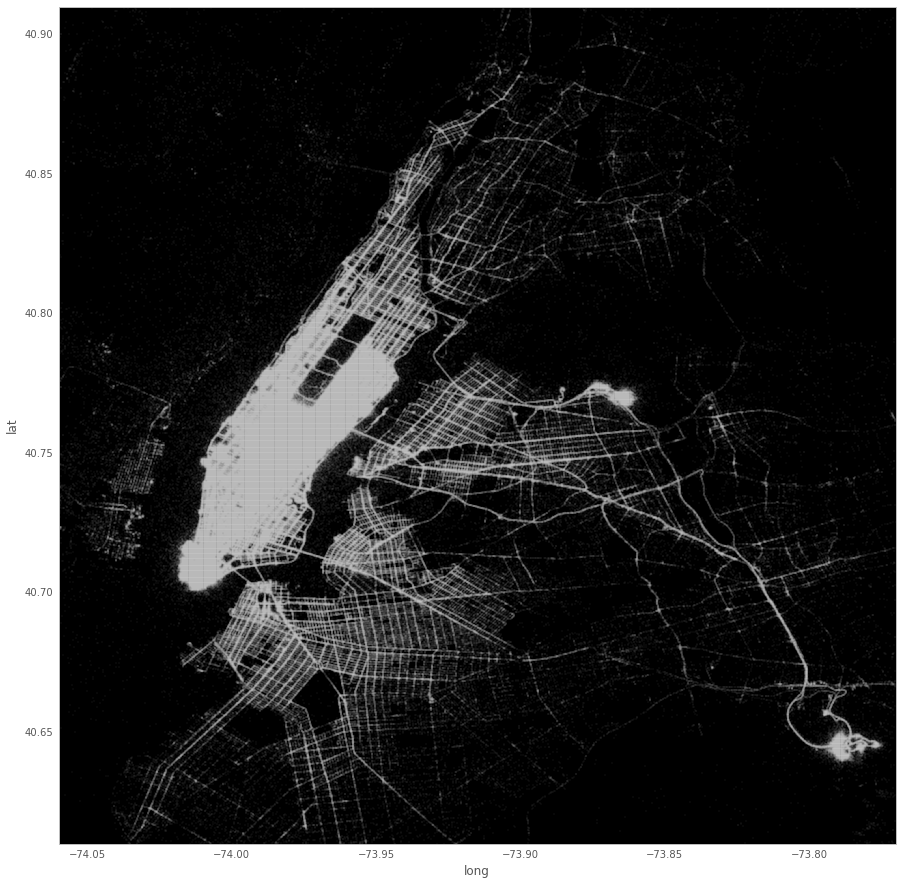

In [9]:
import matplotlib  
import matplotlib.pyplot as plt  
#Inline Plotting for Ipython Notebook 
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

pd.options.display.mpl_style = 'default' #Better Styling  
new_style = {'grid': False} #Remove grid  
matplotlib.rc('axes', **new_style)  
from matplotlib import rcParams  
rcParams['figure.figsize'] = (15, 15) #Size of figure  
rcParams['figure.dpi'] = 125

P=df.plot(kind='scatter', x='long', y='lat',color='white',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)

P.set_axis_bgcolor('black') #Background Color

## Filtering pickups to Manhattan only

We are interested only in trips that were originated in Manhattan. For this we will make use of GeoPandas, and we will need a map of Mahattan. 
Let's fetch the map of Manhattan (from [here](https://github.com/codeforamerica/click_that_hood/tree/master/public/data)) and plot it with Folium.

In [12]:
import geopandas as gpd

#help functions
assets = '/'.join(os.getcwd().split('/')[:-1] + ['assets'])
path = (assets + '/{}').format

manh_df = gpd.read_file(path('nyc_taxi/manhattan.geojson'))

In [82]:
import folium
import os

#let's center on the WTC
manhattan = folium.Map(location=[40.7118, -74.0105], zoom_start=11, tiles='Stamen Toner')

manhattan.geo_json(geo_str=manh_df.to_json().replace("'", r"\'"),
                   line_color='#3186cc',
                    fill_color='#3186cc', line_weight=2,
                   fill_opacity=0.3, reset=True)

In [83]:
manhattan

In [13]:
from shapely.geometry import Point

crs = None
geometry = [Point(xy) for xy in zip(df.long, df.lat)]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [14]:
geo_df.head()

,lat,long,num_pickups,geometry
0,40.7110,-73.7924,1,POINT (-73.7924 40.711)
1,40.7797,-73.9265,1,POINT (-73.9265 40.7797)
2,40.7305,-73.8415,1,POINT (-73.8415 40.7305)
3,40.7556,-73.9462,1,POINT (-73.9462 40.7556)
4,40.8100,-73.8747,1,POINT (-73.8747 40.81)


In [59]:
geo_df['in_manhattan'] = geo_df.intersects(manh_df['geometry'].unary_union)

In [64]:
manhattan_points = geo_df[geo_df['in_manhattan']]

We've now filtered the points to include only those which are contained within Manhattan. We can redo the first plot.

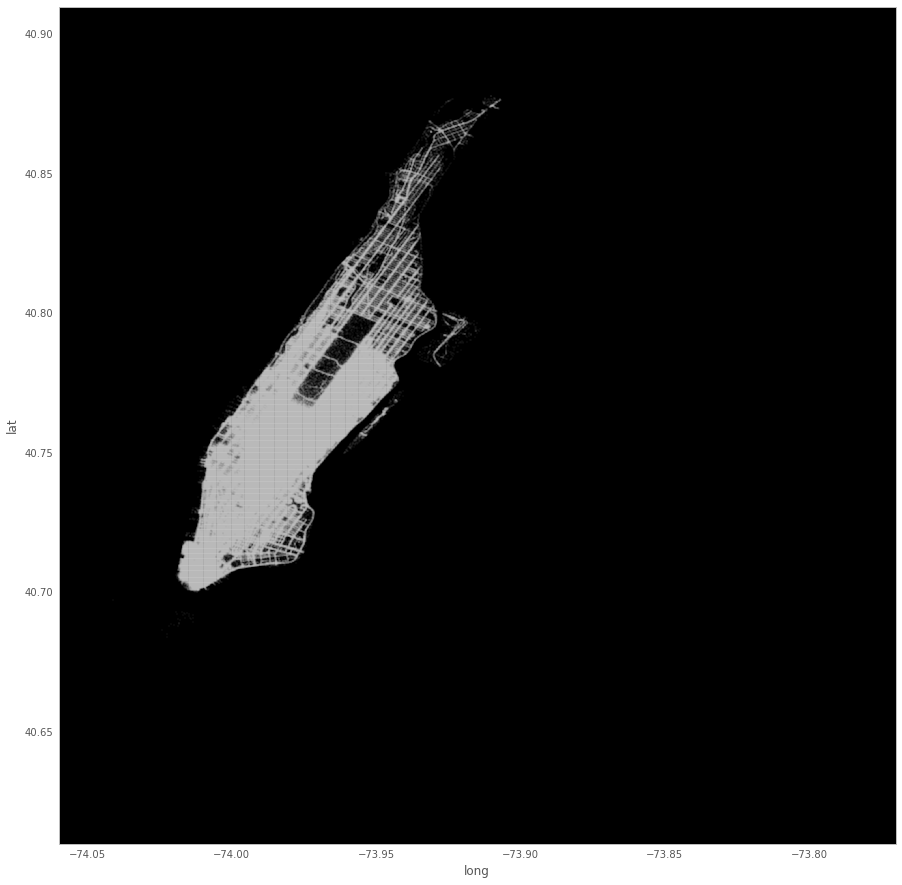

In [67]:
manhattan_points_df = pd.DataFrame(manhattan_points)
P = manhattan_points_df.plot(kind='scatter', x='long', y='lat',color='white',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)

P.set_axis_bgcolor('black') #Background Color

Nice. Next time I would like to try using "within" rather than "intersects" and perhaps plot a nice heatmap on an interactive map.